In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import random
import os

In [10]:
ran_color=False
min_radi=32
image_size=20000
num_circles = 5000
max_radi=1500

if ran_color:
    Dir=f'/DATA/vito/data/ran_synth_{min_radi}_cl_std_000/'
else:
    Dir=f'/DATA/vito/data/ran_synth_{min_radi}_bw/'
if not os.path.exists(Dir[:-1]):
    os.makedirs(Dir[:-1])
    os.makedirs(Dir+'img')
    os.makedirs(Dir+'msk')
for i in range(10):
    image = np.zeros((image_size, image_size, 3), dtype=np.uint8)

    mask = np.zeros((image_size, image_size), dtype=np.uint16)

    circles = []

    for circle_id in range(1, num_circles + 1):
        max_attempts = 100  # Limit the number of attempts to find a non-overlapping position
        for attempt in range(max_attempts):
            radius = random.randint(min_radi, max_radi)

            center_x = random.randint(radius, image_size - radius)
            center_y = random.randint(radius, image_size - radius)
            center = (center_x, center_y)

            # Check for overlap with existing circles
            overlap = False
            for (existing_center, existing_radius) in circles:
                dist = np.sqrt((center_x - existing_center[0]) ** 2 + (center_y - existing_center[1]) ** 2)
                if dist < radius + existing_radius + 1:#+1 so that no contact between circles
                    overlap = True
                    break

            # If no overlap, add the circle and break out of the attempt loop
            if not overlap:
                circles.append((center, radius))
                
                if ran_color:
                    color = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
                else:
                    color = (255,255,255)
                cv2.circle(image, center, radius, color, -1)
                
                cv2.circle(mask, center, radius, circle_id, -1)
                break  

    np.save(Dir+f'img/img_{i:02}',image)
    np.save(Dir+f'msk/msk_{i:02}',mask)


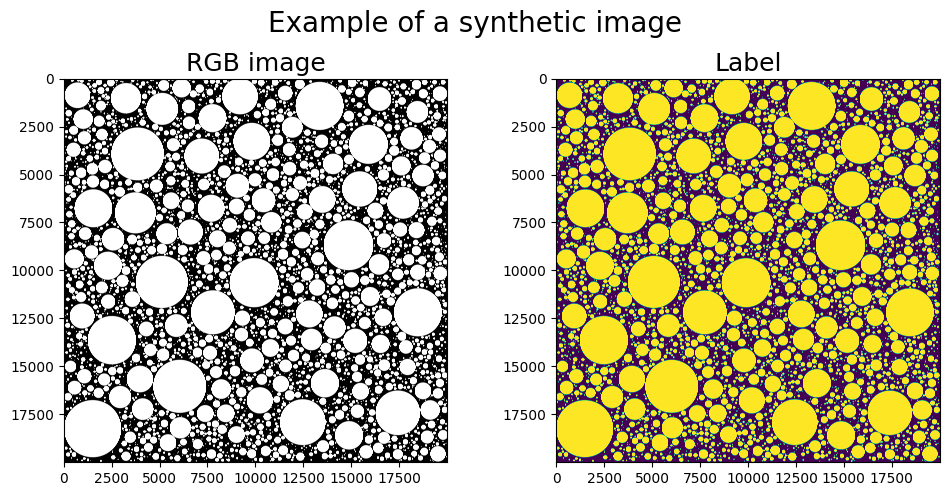

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title('RGB image', fontsize=18)
plt.subplot(1,2,2)
plt.imshow(mask>0)
plt.title('Label', fontsize=18)
plt.suptitle('Example of a synthetic image', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig('/DATA/vito/fig/example_syn_img.pdf')
